In [1]:
import pandas as pd
import numpy as np

# Read in the data
df = pd.read_csv('other/train.csv')
y = df["Habitability_score"].values
ids = df['Property_ID'].values  
df.drop(['Habitability_score', 'Property_ID'], axis=1, inplace=True)
n_data = df.shape[0]

In [3]:
import numpy as np
import pandas as pd

class DataPrep(object):
    def __init__(self, df, y):
        self.df = df.copy()
        self.y = y.copy()
        self.n_data = df.shape[0]
        self.arrs = []
        self.cols = []
        self.nans = []
    
    def search_nan(self):
        for i in self.df:
            for j in self.df[i]:
                if j != j:
                    self.nans.append(i)
                    break

    def train_test_split(self, test_size=0.15, val_size=0.15):
        if self.prepared_df is not None:
            n_train = int(self.n_data*(1 - test_size - val_size))
            n_test = int(self.n_data*(test_size))
            n_val = self.n_data - n_train - n_test
            arr_data = self.prepared_df.to_numpy()
            arr_y = self.y
            np.random.seed(31)
            p = np.random.permutation(len(self.y))
            arr_data = arr_data[p]
            arr_y = arr_y[p]
            if val_size == 0:
                return arr_data[:n_train], arr_y[:n_train], arr_data[n_train:], arr_y[n_train:]
            else:
                return arr_data[:n_train], arr_y[:n_train], arr_data[n_train:n_train+n_val], arr_y[n_train:n_train+n_val], arr_data[n_train+n_val:], arr_y[n_train+n_val:]
        else:
            print("Run prepare() first!!!")
        
    def fill_categorical_nan_and_one_hot_encode(self, col):
        arr = self.df[col].to_numpy()
        dct = dict()
        nan_ind = []

        for i in range(len(arr)):
            element = arr[i]
            if isinstance(element, str) and element != 'nan':
                try:
                    dct[element] += 1
                except:
                    dct[element] = 1
            else:
                nan_ind.append(i)

        nonnan_len = len(arr) - len(nan_ind)
        for i in dct:
            dct[i] = dct[i]/nonnan_len
        for i in nan_ind:
            # arr[i] = np.random.choice(list(dct.keys()), p=list(dct.values()))
            arr[i] = "nan"
        freq_arr = np.zeros(len(dct.keys()))
        uni_vals = np.unique(arr).tolist()
        uni_vals.remove("nan")
        encoded_arr = np.zeros((self.n_data, len(uni_vals)))
        encod_dict = dict()
        for i in range(len(uni_vals)):
            encod_dict[uni_vals[i]] = i
        for i in range(len(freq_arr)):
            freq_arr[i] = dct[uni_vals[i]]
        for i in range(self.n_data):
            if arr[i] == "nan":
                encoded_arr[i] = freq_arr.copy()
            else:
                encoded_arr[i][encod_dict[arr[i]]] = 1
        return encoded_arr, encod_dict

    def fill_numerical_nan(self, col):
        return self.df[col].fillna(self.df[col].mean())

    def one_hot_encode_not_nan(self, col):
        arr = self.df[col].to_numpy()
        dct = dict()

        for i in range(len(arr)):
            element = arr[i]
            try:
                dct[element] += 1
            except:
                dct[element] = 1

        uni_vals = np.unique(arr).tolist()
        encoded_arr = np.zeros((self.n_data, len(uni_vals)))
        encod_dict = dict()
        for i in range(len(uni_vals)):
            encod_dict[uni_vals[i]] = i
        for i in range(self.n_data):
            encoded_arr[i][encod_dict[arr[i]]] = 1
        return encoded_arr, encod_dict

    def normalize_numerical(self, arr):
        return (arr - arr.mean())/arr.std()

    def prepare(self):
        d_types = self.df.dtypes
        self.search_nan()
        for i in self.df:
            if i in self.nans:
                if d_types[i] == "object":
                    ret_tuple = self.fill_categorical_nan_and_one_hot_encode(i)
                    for k in ret_tuple[0].T:
                        self.arrs.append(k)
                    for j in ret_tuple[1]:
                        self.cols.append(i+'_'+j)
                else:
                    self.arrs.append(self.normalize_numerical(self.fill_numerical_nan(i)))
                    self.cols.append(i)
            else:
                if d_types[i] == "object":
                    ret_tuple = self.one_hot_encode_not_nan(i)
                    for k in ret_tuple[0].T:
                        self.arrs.append(k)
                    for j in ret_tuple[1]:
                        self.cols.append(i+'_'+j)
                else:
                    self.arrs.append(self.normalize_numerical(self.df[i]))
                    self.cols.append(i)
        self.prepared_df = pd.DataFrame(np.array(self.arrs).T, columns=self.cols)
        return pd.DataFrame(np.array(self.arrs).T, columns=self.cols), self.y


In [4]:
def calculate_loss(net, X, y):
    y_hat = net.test(X)
    y_hat = np.array(y_hat.tolist())
    y_hat = y_hat.squeeze()
    y = np.array(y.tolist())
    y = y.squeeze()
    return np.mean((y_hat - y)**2)

def plot(loss, valloss):
    import matplotlib.pyplot as plt
    plt.plot(loss, label = 'train loss')
    plt.plot(valloss, label = 'validation loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()


In [7]:
df = pd.read_csv('other/train.csv')
y = df["Habitability_score"].values
ids = df['Property_ID'].values  
df.drop(['Habitability_score', 'Property_ID'], axis=1, inplace=True)
preparator = DataPrep(df, y)
PreparedData, labels = preparator.prepare()
X_train, y_train, X_val, y_val, X_test, y_test = preparator.train_test_split(0.15, 0.15)
n_data, n_features = PreparedData.shape[0:2]
X = X_train
y = y_train
print("%d data available with %d features (some are one hot encoded)"%(n_data, n_features))
print("%d, %d, %d"%(X_train.shape[0], X_val.shape[0], X_test.shape[0]))

39499 data available with 31 features (some are one hot encoded)
27649, 5926, 5924


In [9]:
X = PreparedData.to_numpy()
y = labels
n_features = X.shape[1]
"%d data available with %d features (some are one hot encoded)"%(n_data, n_features)

'39499 data available with 31 features (some are one hot encoded)'

In [1]:
import numpy as np
X_train = np.load('data/X_train.npy')
y_train = np.load('data/y_train.npy')
X_val = np.load('data/X_val.npy')
y_val = np.load('data/y_val.npy')
X_test = np.load('data/X_test.npy')
y_test = np.load('data/y_test.npy')

In [15]:
from NeuralNetwork import NeuralNetwork as nn
from data_layer import Dataset
from pyflow import Tensor, L1Loss, L2Loss, FullyConnected, SGD, CrossEntropyLoss, ReLU, Sigmoid, Dropout
from gc import collect
collect()

y_val = Tensor(y_val[:, None, None]) if type(y_val) == np.ndarray else y_val
batch_size = 2048
dataset = Dataset(X_train, y_train, batch_size, True)
loss_layer = L2Loss()
net = nn(dataset, loss_layer)

in_size = X_train.shape[1]
hidden_sizes = (24, 16, 8, 4, 2)
out_size = 1

momentum = 0
lr = 0.05
Optimizer = 'Adam'
Initializer = 'xavier'
Regularizer = 'L2Regularizer'
lamda = 0.01
mu = 0.9
rho = 0.999

my_layers = []
my_activations = []
my_layers.append(FullyConnected(in_size, hidden_sizes[0], lr, Optimizer, momentum, mu, rho, Initializer, Regularizer, lamda)) # 0
my_layers.append(FullyConnected(hidden_sizes[0], hidden_sizes[1], lr, Optimizer, momentum, mu, rho, Initializer, Regularizer, lamda)) # 1
my_layers.append(FullyConnected(hidden_sizes[1], hidden_sizes[2], lr, Optimizer, momentum, mu, rho, Initializer, Regularizer, lamda)) # 2
my_layers.append(FullyConnected(hidden_sizes[2], hidden_sizes[3], lr, Optimizer, momentum, mu, rho, Initializer, Regularizer, lamda)) # 3
my_layers.append(FullyConnected(hidden_sizes[3], hidden_sizes[4], lr, Optimizer, momentum, mu, rho, Initializer, Regularizer, lamda)) # 4
my_layers.append(FullyConnected(hidden_sizes[4], out_size, lr, Optimizer, momentum, mu, rho, Initializer, Regularizer, lamda))  # 5

my_activations.append(ReLU())
my_activations.append(ReLU())
my_activations.append(ReLU())
my_activations.append(ReLU())
my_activations.append(ReLU())

# dropouts = [Dropout(0.1), Dropout(0.1), Dropout(0.1), Dropout(0.1)]

net.append_layer(my_layers[0])
net.append_layer(my_activations[0])
# net.append_layer(dropouts[0])
net.append_layer(my_layers[1])
net.append_layer(my_activations[1])
# net.append_layer(dropouts[1])
net.append_layer(my_layers[2])
net.append_layer(my_activations[2])
net.append_layer(my_layers[3])
net.append_layer(my_activations[3])
# net.append_layer(dropouts[2])
net.append_layer(my_layers[4])
net.append_layer(my_activations[4])
# net.append_layer(dropouts[3])
net.append_layer(my_layers[5])

epochs = 150
loss, valloss = net.train(epochs, cross_val = True, valset = (X_val, y_val), verbose = True)
collect()
name_str = f'{hidden_sizes} {batch_size}, {lr}, {momentum}, {Optimizer}, {my_activations[0].__class__.__name__}, {loss_layer.__class__.__name__}, {epochs}, {loss[-1]}, {valloss[-1]}'
np.save(f'runs/loss_with_{name_str}.npy', loss)
np.save(f'runs/valloss_with_{name_str}.npy', valloss)
with open('runs/train_hist.txt', 'a') as f:
    print(name_str, file=f)

Epoch:    1
	Train Loss: 10422.33	Val Loss: 5207.72
Epoch:    2
	Train Loss: 5144.64	Val Loss: 5001.30
Epoch:    3
	Train Loss: 4904.57	Val Loss: 4738.90
Epoch:    4
	Train Loss: 4624.64	Val Loss: 4443.14
Epoch:    5
	Train Loss: 4314.16	Val Loss: 4109.57
Epoch:    6
	Train Loss: 3961.63	Val Loss: 3734.85
Epoch:    7
	Train Loss: 3559.89	Val Loss: 3311.07
Epoch:    8
	Train Loss: 3105.63	Val Loss: 2817.50
Epoch:    9
	Train Loss: 2586.88	Val Loss: 2276.68
Epoch:   10
	Train Loss: 2032.72	Val Loss: 1714.64
Epoch:   11
	Train Loss: 1472.92	Val Loss: 1203.60
Epoch:   12
	Train Loss: 992.91	Val Loss: 783.53
Epoch:   13
	Train Loss: 664.59	Val Loss: 527.54
Epoch:   14
	Train Loss: 493.07	Val Loss: 453.04
Epoch:   15
	Train Loss: 444.84	Val Loss: 447.98
Epoch:   16
	Train Loss: 449.11	Val Loss: 448.49
Epoch:   17
	Train Loss: 459.11	Val Loss: 430.25
Epoch:   18
	Train Loss: 428.73	Val Loss: 435.00
Epoch:   19
	Train Loss: 429.99	Val Loss: 434.69
Epoch:   20
	Train Loss: 444.97	Val Loss: 429.

KeyboardInterrupt: 

In [ ]:
calculate_loss(net, X_val, y_val), calculate_loss(net, X, y)
import matplotlib.pyplot as plt
t = np.arange(0, epochs)
loss = net.loss
valloss = net.vallosses
plt.plot(t, loss, label = 'train loss')
plt.plot(t, valloss, label = 'validation loss')
plt.legend()
print(valloss)

In [ ]:
net.save_model('model_Adam_48_valllos')

In [ ]:
from os import listdir
for i in listdir('runs'):
    if i.startswith('loss_with_'):
        name = i[10:]
        train_loss = np.load(f'runs/{i}', allow_pickle=True)
        val_loss = np.load(f'runs/valloss_with_{name}', allow_pickle=True)
        labels = name[:-4]
        plot(train_loss, val_loss)
        splitted = labels.split(', ')
        try:
            splitted[-2] = float(splitted[-2])
            splitted[-1] = float(splitted[-1])
            print(", ".join(splitted[:-2]), "%.2f"%splitted[-2], "%.2f"%splitted[-1])
        except:
            print(labels)

In [2]:
from NeuralNetwork import NeuralNetwork as nn
from data_layer import Dataset
from pyflow import Tensor, L1Loss, L2Loss, FullyConnected, SGD, CrossEntropyLoss, ReLU, Dropout
from gc import collect
import numpy as np
collect()

layer = FullyConnected(31, 16, 1e-3, 'SGD')
dropout = Dropout(0.8)
layer2 = FullyConnected(16, 8, 1e-3, 'SGD')
dropout2 = Dropout(0.8)
layer3 = FullyConnected(8, 4, 1e-3, 'SGD')
layer4 = FullyConnected(4, 1, 1e-3, 'SGD')

net = nn('SGD', path='saved_models/model_Adam_48_valllos')
net.append_layer(layer)
net.append_layer(ReLU())
net.append_layer(dropout)
net.append_layer(layer2)
net.append_layer(ReLU())
net.append_layer(dropout2)
net.append_layer(layer3)
net.append_layer(ReLU())
net.append_layer(layer4)

net.loss_layer = L2Loss()

net.save_model('model')

306.79s - Error inserting pydevd breaks.
Traceback (most recent call last):
  File "/home/samil/.local/lib/python3.8/site-packages/debugpy/_vendored/pydevd/_pydevd_frame_eval/pydevd_modify_bytecode.py", line 328, in insert_pydevd_breaks
    for new_instruction in get_instructions_to_add(
  File "/home/samil/.local/lib/python3.8/site-packages/debugpy/_vendored/pydevd/_pydevd_frame_eval/pydevd_modify_bytecode.py", line 102, in get_instructions_to_add
    Instr("LOAD_CONST", _pydev_stop_at_break, lineno=stop_at_line - 1),
  File "/home/samil/.local/lib/python3.8/site-packages/debugpy/_vendored/pydevd/_pydevd_frame_eval/vendored/bytecode/instr.py", line 171, in __init__
    self._set(name, arg, lineno)
  File "/home/samil/.local/lib/python3.8/site-packages/debugpy/_vendored/pydevd/_pydevd_frame_eval/vendored/bytecode/instr.py", line 239, in _set
    _check_lineno(lineno)
  File "/home/samil/.local/lib/python3.8/site-packages/debugpy/_vendored/pydevd/_pydevd_frame_eval/vendored/bytecode/ins

KeyboardInterrupt: 

In [ ]:
net2 = nn('SGD')
net2.load_model('model')

In [2]:
for i in range(len(net.layers)):
    if net.layers[i].__class__.__name__ == 'FullyConnected':
        W1 = np.array(net.layers[i].weights.tolist())[0]
        W2 = np.array(net2.layers[i].weights.tolist())[0]
        b1 = np.array(net.layers[i].bias.tolist())[0]
        b2 = np.array(net2.layers[i].bias.tolist())[0]
        print(np.allclose(W1, W2))
        print(np.allclose(b1, b2))

NameError: name 'net2' is not defined

In [7]:
net.layers[-1]

0.592845 0.844266 0.857946 0.847252 

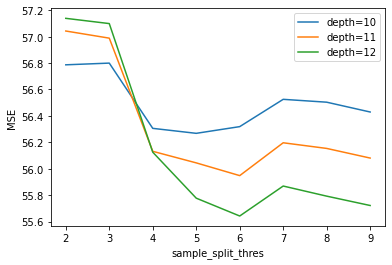

In [1]:
losses = []
losses.append([56.78696963411451, 56.79988706577163, 56.30567087769273, 56.26798248379765, 56.31875922801334, 56.52551989496126, 56.50387365186174, 56.42948998183488])
losses.append([57.04300139394967, 56.98894406607251, 56.1317550632788, 56.04419688826381, 55.947680315078784, 56.19645383998316, 56.153669585505305, 56.08066101954237])
losses.append([57.13901215974242, 57.0993010983182, 56.12516216489861, 55.77690033684333, 55.64173109781663, 55.86875157070448, 55.79222879860492, 55.721369012839155])
splits = [2, 3, 4, 5, 6, 7, 8, 9]

import matplotlib.pyplot as plt

plt.plot(splits, losses[0], label='depth=10')
plt.plot(splits, losses[1], label='depth=11')
plt.plot(splits, losses[2], label='depth=12')
plt.legend()
plt.xlabel('sample_split_thres')
plt.ylabel('MSE')
plt.show()